In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data.dataloader as dataloader
from torchinfo import summary
import numpy as np
import torch.nn.functional as F

# Data loading and Pre-processing

In [2]:
batch_size = 64
num_classes = 10
num_epochs = 15
num_channels = 1
learning_rate = 0.001
patch_size = 7
image_size = 28
patch_number = (image_size/patch_size) ** 2
attention_heads = 8
embedding_dim = 128
transformer_layers = 6
mlp_dim = 256
dropout = 0.1

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

In [4]:
train_data = dataloader.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_data = dataloader.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Class for Patch_Embedding

In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=num_channels, embed_dim=embedding_dim, patch_size=patch_size):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, N)
        x = x.transpose(1, 2)  # (B, N, embed_dim)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim = embedding_dim, attention_heads = attention_heads, dropout = dropout, mlp_dim =mlp_dim) -> None:
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.multi_head_attention = nn.MultiheadAttention(embed_dim, attention_heads, dropout, bias = True)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, embed_dim)
        )
        self.attn_weights = None

    def forward(self, x):
        # x: (B, N, embed_dim) -> transpose to (N, B, embed_dim)
        x = x.transpose(0, 1)

        residual_1 = x
        x = self.layer_norm_1(x)
        attn_out, attn_weights = self.multi_head_attention(
            x, x, x,
            need_weights=True,
            average_attn_weights=False
        )
        self.attn_weights = attn_weights.detach()
        x = attn_out + residual_1

        residual_2 = x
        x = self.layer_norm_2(x)
        x = self.mlp(x) + residual_2

        # transpose back to (B, N, embed_dim)
        x = x.transpose(0, 1)
        return x
    
class MLPhead(nn.Module):
    def __init__(self, embed_dim = embedding_dim, mlp_dim =mlp_dim) -> None:
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.mlp_head = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.Linear(mlp_dim, embed_dim)
        )
    def forward(self, x):
        x = self.layer_norm_1(x)
        x = self.mlp_head(x)
        return x
    
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels,
                 embed_dim, depth,
                 num_heads, mlp_dim, dropout):
        super().__init__()

        self.patch_embed = PatchEmbedding(in_channels, embed_dim, patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
            torch.randn(1, (img_size // patch_size) ** 2 + 1, embed_dim)
        )

        self.transformer_blocks = nn.ModuleList([
            TransformerEncoder(embed_dim, num_heads, dropout, mlp_dim)
            for _ in range(depth)
        ])

        self.mlp_head = MLPhead()

    def forward(self, x):
        B = x.size(0)

        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed

        self.attentions = []  # <-- reset each forward

        for block in self.transformer_blocks:
            x = block(x)
            self.attentions.append(block.attn_weights)

        x = x[:, 0]        # CLS token
        x = self.mlp_head(x)
        return x


In [6]:
def attention_rollout(attentions):
    """
    attentions: list of (B, heads, N, N)
    """
    B, H, N, _ = attentions[0].shape
    device = attentions[0].device

    R = torch.eye(N, device=device).unsqueeze(0).repeat(B, 1, 1)

    for attn in attentions:
        attn = attn.mean(dim=1)
        attn = attn + torch.eye(N, device=device)
        attn = attn / attn.sum(dim=-1, keepdim=True)
        R = torch.bmm(attn, R)

    return R

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer(img_size=image_size,
    patch_size=patch_size,
    in_channels=num_channels,
    embed_dim=embedding_dim,
    depth=transformer_layers,
    num_heads=attention_heads,
    mlp_dim=mlp_dim,
    dropout=dropout
).to(device)
state_dict = torch.load("../trained_vit_mnist.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(1, 128, kernel_size=(7, 7), stride=(7, 7))
  )
  (transformer_blocks): ModuleList(
    (0-5): 6 x TransformerEncoder(
      (layer_norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (multi_head_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (layer_norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
    )
  )
  (mlp_head): MLPhead(
    (layer_norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (mlp_head): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=128, bias=True)
    )
  )
)

In [8]:
def upsample_heatmap(heatmap, img_size):
    heatmap = heatmap.unsqueeze(0).unsqueeze(0)  # (1,1,h,w)
    heatmap = F.interpolate(
        heatmap,
        size=(img_size, img_size),
        mode='bilinear',
        align_corners=False
    )
    return heatmap.squeeze()

def normalize_heatmap(h):
    h = h - h.min()
    h = h / (h.max() + 1e-8)
    return h

def tensor_to_image(img):
    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    return img

def visualize_rollout(image, heatmap, alpha=0.5):
    heatmap = heatmap.cpu().numpy()
    image = tensor_to_image(image)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(heatmap, cmap="jet")
    axes[1].set_title("Rollout Heatmap")
    axes[1].axis("off")

    axes[2].imshow(image)
    axes[2].imshow(heatmap, cmap="jet", alpha=alpha)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


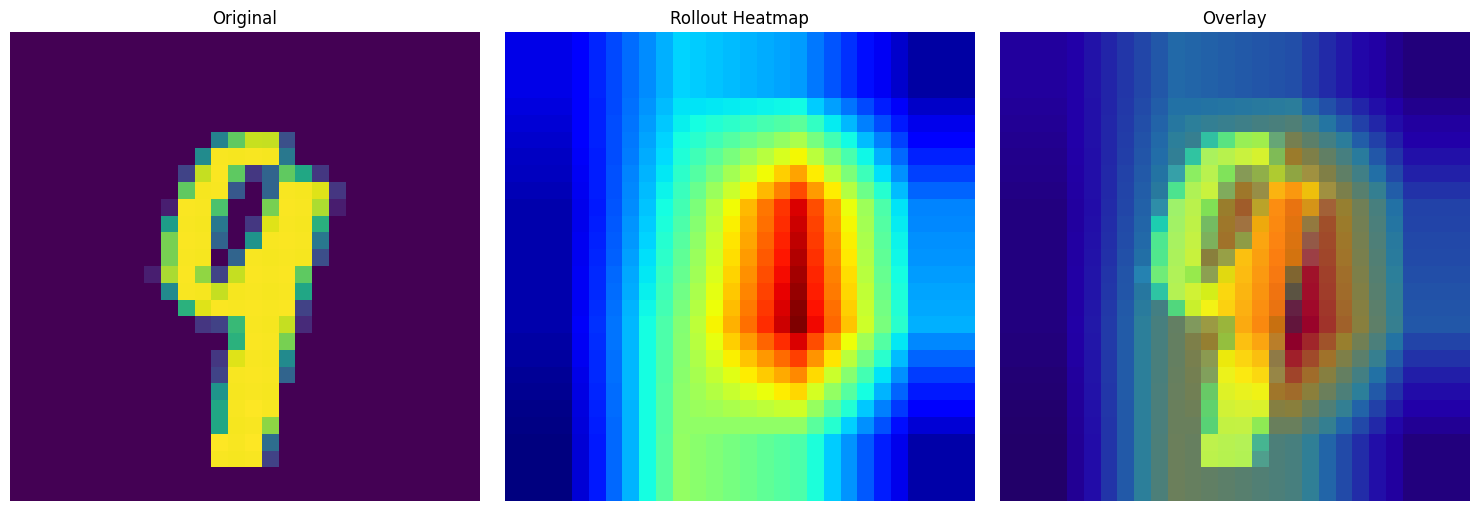

In [30]:
model.eval()
images, labels = next(iter(test_data))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    _ = model(images[0].unsqueeze(0))
    rollout = attention_rollout(model.attentions)

cls_attention = rollout[0, 0, 1:]
grid = int(cls_attention.shape[0] ** 0.5)
heatmap = cls_attention.reshape(grid, grid)

heatmap = normalize_heatmap(heatmap)
heatmap = upsample_heatmap(heatmap, image_size)

visualize_rollout(images[0], heatmap)
